In [1]:
!ls

conv.py  decoder_model_sanity_check.ipynb  my_diffusers  res.py


In [2]:
!pwd

/home/jh27kim/warp_latent/model


In [3]:
import sys
sys.path.append(".")
sys.path.append("..")

import os
from my_diffusers.models.autoencoder_kl import AutoencoderKL
from diffusers import StableDiffusionPipeline
from utils import image_utils, transformation_utils
import torch
from PIL import Image
import random
import numpy as np

In [4]:
device = torch.device('cuda:9') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token='')
stable_diffusion_vae = ldm_stable.vae
stable_diffusion_vae.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

In [5]:
ckpt_path = "/home/jh27kim/warp_latent/ckpt/dec_ep_5.pt"
state_dict = torch.load(ckpt_path)

# Use get_attr
# class_obj = AutoencoderKL
# load_method_name = "from_pretrained"
# load_method = getattr(AutoencoderKL, load_method_name)
# l_path = "/home/jh27kim/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/b95be7d6f134c3a9e62ee616f310733567f069ce/vae"
# loading_kwargs = {'torch_dtype': None, 'device_map': None, 'variant': None, 'low_cpu_mem_usage': False}
# loaded_sub_model = load_method(l_path, **loading_kwargs)

# Use from_trained method
loaded_sub_model = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
loaded_sub_model.decoder.load_state_dict(state_dict["decoder"])
loaded_sub_model.to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

In [6]:
image_path = "/home/jh27kim/warp_latent/dataset/afhq/val/cat/image"
image_path = [os.path.join(image_path, i) for i in os.listdir(image_path)]
print(image_path[0], len(image_path))

/home/jh27kim/warp_latent/dataset/afhq/val/cat/image/pixabay_cat_002201.jpg 500


In [7]:
scale = torch.ones(1)
ind = random.randint(0, len(image_path))

img_path = image_path[ind]
with torch.no_grad():
    src_img = Image.open(img_path)
    src_img = (np.array(src_img) / 255.0).astype(np.float32)
    src_img = torch.tensor(src_img).permute(2, 0, 1).unsqueeze(0).to(device)

    src_latent = image_utils.image2latent(src_img, stable_diffusion_vae)
    angle = (torch.rand(1) - 0.5) * 2 # -1 ~ 1
    angle *= 180.0

    latent_center = torch.ones(1, 2)
    latent_center[..., 0] = src_latent.shape[3] / 2  # x
    latent_center[..., 1] = src_latent.shape[2] / 2  # y

    _, _, latent_h, latent_w = src_latent.shape
    
    latent_SO2 = transformation_utils.get_rotation_matrix2d(latent_center.to(src_img), 
                                                            angle.to(src_img), 
                                                            scale.to(src_img))
    
    SO2_warp_latent = transformation_utils.warp_affine(src_latent, 
                                                       latent_SO2, 
                                                       dsize=(latent_h, latent_w), 
                                                       interpolation_mode="bilinear", 
                                                       padding_mode="reflection")

    res_autoencoder = image_utils.latent2image(SO2_warp_latent, 
                                               vae=loaded_sub_model)
    
    res_stable_diffusion_autoencoder = image_utils.latent2image(SO2_warp_latent, 
                                                                vae=stable_diffusion_vae)

    # Image warp
    img_center = torch.ones(1, 2)
    img_center[..., 0] = src_img.shape[3] / 2  # x
    img_center[..., 1] = src_img.shape[2] / 2  # y
    img_SO2 = transformation_utils.get_rotation_matrix2d(img_center.to(src_img), 
                                    angle.to(src_img), 
                                    scale.to(src_img)) 
    
    _, _, img_h, img_w = src_img.shape

    tar_img = transformation_utils.warp_affine(src_img, 
                          img_SO2, 
                          dsize=(img_h, img_w), 
                          interpolation_mode="bilinear", 
                          padding_mode="reflection")

/home/jh27kim/miniconda3/envs/diffusion_inv/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/jh27kim/miniconda3/envs/diffusion_inv/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


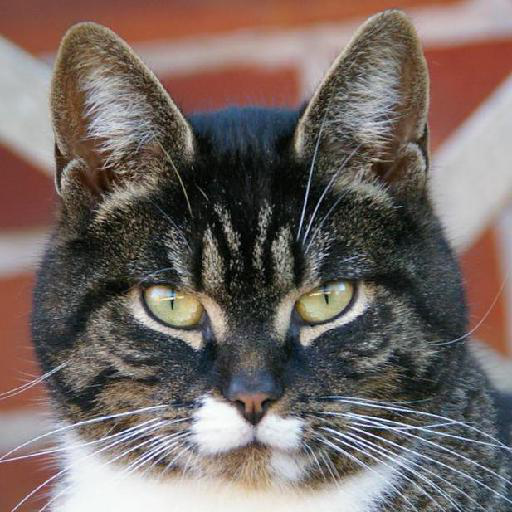

In [8]:
image_utils.torch_to_pil(src_img)

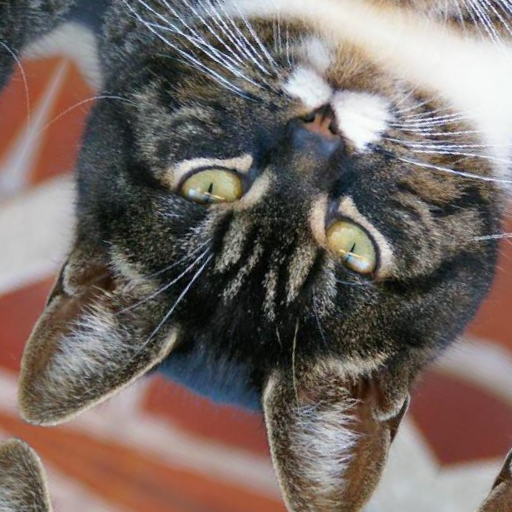

In [9]:
image_utils.torch_to_pil(tar_img)

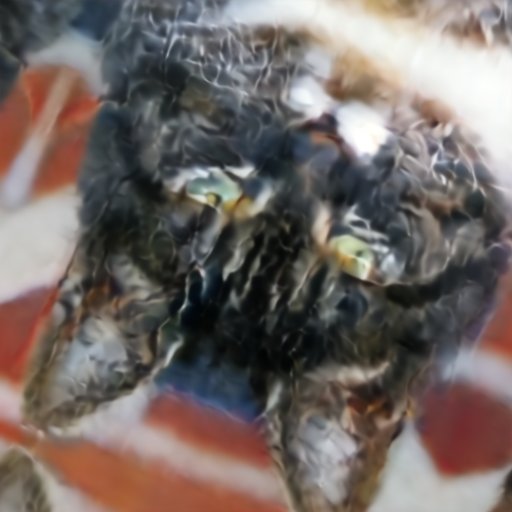

In [10]:
image_utils.torch_to_pil(res_autoencoder)

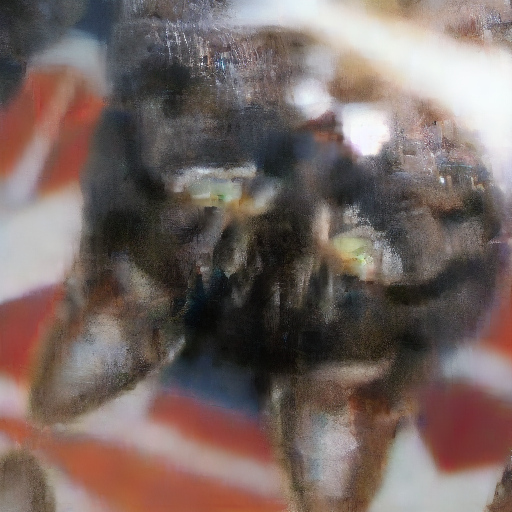

In [11]:
image_utils.torch_to_pil(res_stable_diffusion_autoencoder)